# Лабораторная работа 4. Логические методы классификации

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline

import seaborn as sns
from matplotlib import pyplot as plt

data_path = 'imports-85.data'

d = pd.read_csv(data_path, delimiter=',',

                names=["symboling", "normalized-losses", "make", "fuel-type", "aspiration",

                       "num-of-doors", "body-style", "drive-wheels", "engine-location", "wheel-base",

                       "length", "width", "height", "curb-weight", "engine-type", "num-of-cylinders",

                       "engine-size", "fuel-system", "bore", "stroke", "compression-ratio", "horsepower",

                       "peak-rpm", "city-mpg", "highway-mpg", "price"],

                header=None)

# Заменяем '?' на NaN, конвертируем столбцы в числовые, где это возможно
d.replace('?', np.nan, inplace=True)

# Обработаем возможные нечисловые данные в столбцах 'city-mpg', 'highway-mpg', 'price'

d['city-mpg'] = pd.to_numeric(d['city-mpg'], errors='coerce')
d['highway-mpg'] = pd.to_numeric(d['highway-mpg'], errors='coerce')
d['price'] = pd.to_numeric(d['price'], errors='coerce')

# Удаляем строки с NaN, чтобы обеспечить чистоту данных
d.dropna(subset=['city-mpg', 'highway-mpg', 'price'], inplace=True)


dX = d[['city-mpg', 'highway-mpg', 'price']]
dy = d['fuel-type']

print(dX.head())
print(dy.head())

   city-mpg  highway-mpg    price
1      21.0         27.0  13495.0
2      21.0         27.0  16500.0
3      19.0         26.0  16500.0
4      24.0         30.0  13950.0
5      18.0         22.0  17450.0
1    gas
2    gas
3    gas
4    gas
5    gas
Name: fuel-type, dtype: object


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Подмножества для hold-out
X_train, X_holdout, y_train, y_holdout = \
train_test_split(dX, dy, test_size=0.3, random_state=12)

# Обучение модели
tree = DecisionTreeClassifier(max_depth=5,
                              random_state=21,
                              max_features=2)
tree.fit(X_train, y_train)

# Получение оценки hold-out
tree_pred = tree.predict(X_holdout)
accur = accuracy_score(y_holdout, tree_pred)
print(accur)

0.9354838709677419


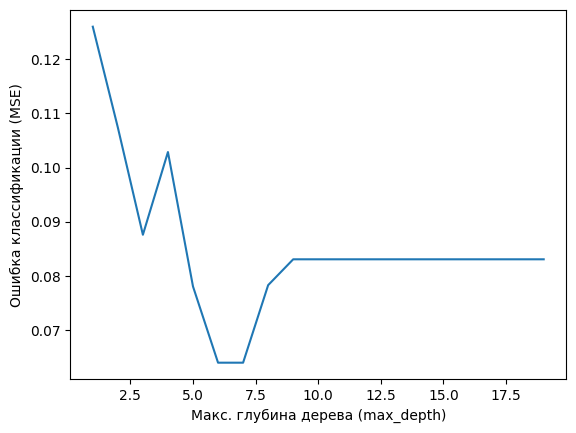

Оптимальные значения max_depth:  [6, 7]


In [ ]:
from sklearn.model_selection import cross_val_score

# Значения параметра max_depth
d_list = list(range(1,20))
# Пустой список для хранения значений точности
cv_scores = []
# В цикле проходим все значения K
for d in d_list:
    tree = DecisionTreeClassifier(max_depth=d,
                                  random_state=21,
                                  max_features=2)
    scores = cross_val_score(tree, dX, dy, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Вычисляем ошибку (misclassification error)
MSE = [1-x for x in cv_scores]

# Строим график
plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
d_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_d_min = []
for i in range(len(MSE)):
    if MSE[i] <= d_min:
        all_d_min.append(d_list[i])

# печатаем все K, оптимальные для модели
print('Оптимальные значения max_depth: ', all_d_min)

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import tree

dtc = DecisionTreeClassifier(max_depth=10, random_state=21, max_features=2)

tree_params = { 'max_depth': range(1,20), 'max_features': range(1,4) }
tree_grid = GridSearchCV(dtc, tree_params, cv=10, verbose=True, n_jobs=-1)
tree_grid.fit(dX, dy)

print('\n')
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

# Генерируем графическое представление лучшего дерева (сохранится в файле)
tree.export_graphviz(tree_grid.best_estimator_,
                     feature_names=dX.columns,
                     class_names=dy.unique(),
                     out_file='cars85.dot',
                     filled=True, rounded=True)

Fitting 10 folds for each of 57 candidates, totalling 570 fits


Лучшее сочетание параметров:  {'max_depth': 7, 'max_features': 3}
Лучшие баллы cross validation:  0.9561904761904761


Оптимальное дерево решений


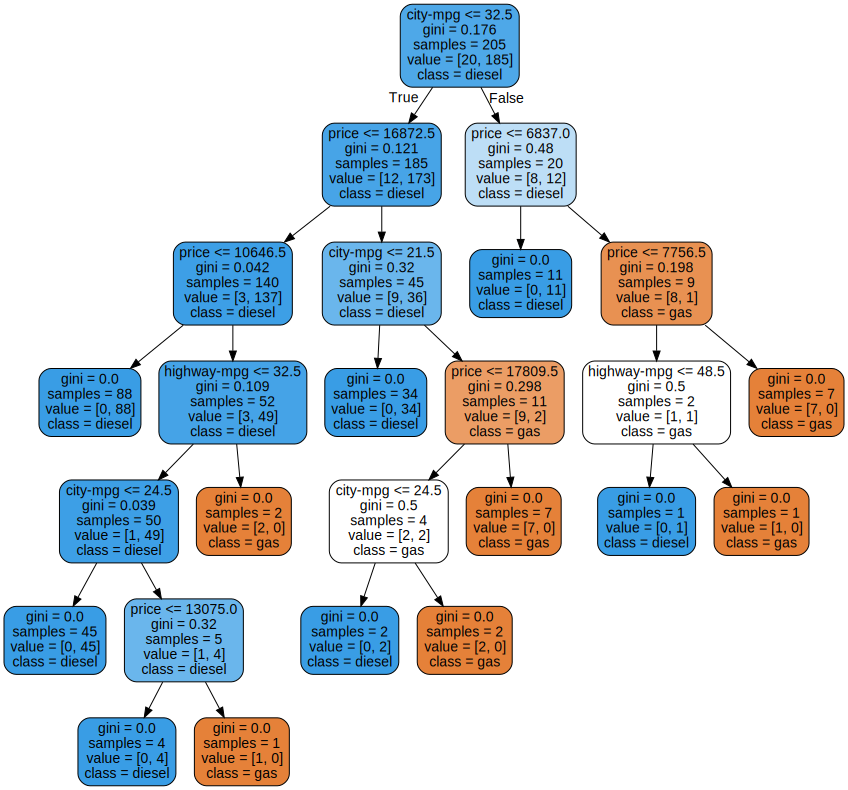

In [ ]:
# На самом деле можно визуализировать в Google Colab следующим бразом
import graphviz
dot_data = tree.export_graphviz(tree_grid.best_estimator_,
                     feature_names=dX.columns,
                     class_names=dy.unique(),
                     out_file=None,
                     filled=True, rounded=True)
graph = graphviz.Source(dot_data)
print('Оптимальное дерево решений')
graph

In [ ]:
# Поэкспериментируем с визуализацией деревьев...
# max_features = 2, max_depth = 3
dtc = DecisionTreeClassifier(max_depth=5,
                             random_state=21,
                             max_features=1)
# Обучаем
dtc.fit(dX.values, dy)
# Предсказываем
res = dtc.predict([[5.1, 3.5, 1.4]])
print(res)

['gas']


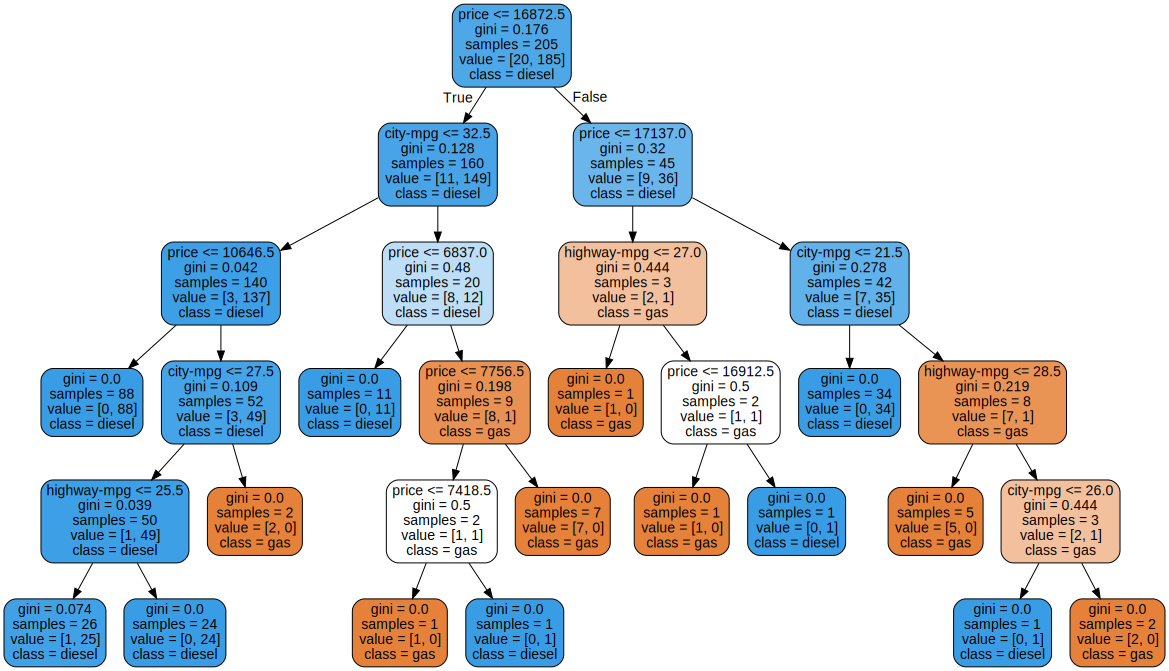

In [ ]:
dot_data = tree.export_graphviz(dtc,
                     feature_names=dX.columns,
                     class_names=dy.unique(),
                     out_file=None,
                     filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

Построим границы решений для модели

In [ ]:
# Палитры
print(sorted(list(plt.colormaps)))

['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


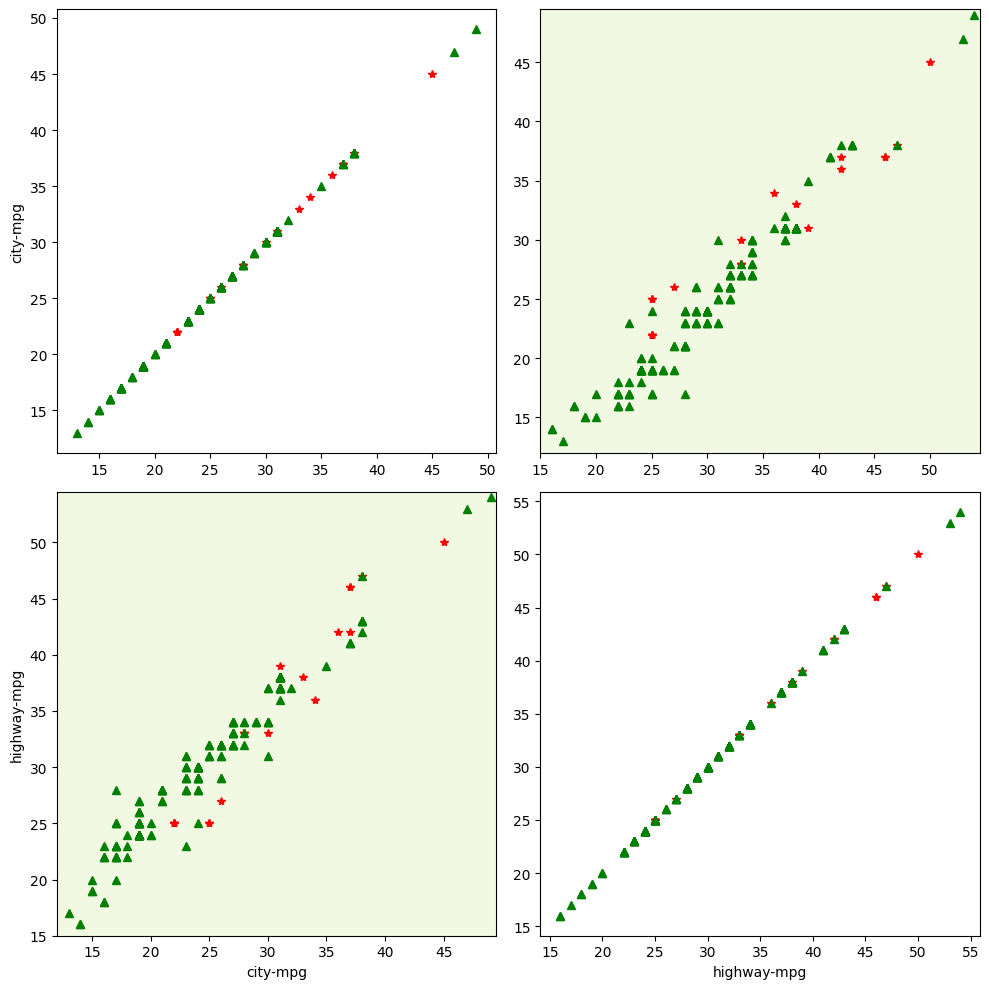

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# Преобразование категорий в числовые метки

encoder = LabelEncoder()

dy_encoded = encoder.fit_transform(dy)

answers = np.unique(dy_encoded)

plot_markers = ['r*', 'g^']



# Уменьшение размера сетки

plot_step = 0.5  # увеличено с 0.1

fmin = dX.min() - 1

fmax = dX.max() + 1



# Сокращение числа подграфиков

labels = ["city-mpg", "highway-mpg"]  # упрощение, используем только 2 признака

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))  # меньше подграфиков



for i in range(2):

    for j in range(2):

        ax = axes[i, j]

        if i != j:

            xx, yy = np.meshgrid(np.arange(fmin[j], fmax[j], plot_step), np.arange(fmin[i], fmax[i], plot_step))

            model = DecisionTreeClassifier(max_depth=3, random_state=42)

            model.fit(dX[[labels[j], labels[i]]], dy_encoded)

            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

            Z = Z.reshape(xx.shape)

            ax.contourf(xx, yy, Z, alpha=0.5, levels=np.unique(Z), cmap=plt.cm.Pastel2)



        for answer, marker in zip(answers, plot_markers):

            points_idx = (dy_encoded == answer)

            ax.plot(dX.iloc[points_idx, j], dX.iloc[points_idx, i], marker, label=encoder.inverse_transform([answer])[0])



        if j == 0:

            ax.set_ylabel(labels[i])

        if i == 1:

            ax.set_xlabel(labels[j])



plt.tight_layout()

plt.show()